In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
import csv
import random
%matplotlib inline
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.formula.api import mixedlm

from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
from common_functions import remove_unit_variance
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

In [3]:
df = pd.read_csv('../data/wm_task_questionnaires.csv')


/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_54719/3500902083.py:1: DtypeWarning: Columns (254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wm_task_questionnaires.csv')


In [6]:
scaler = StandardScaler()

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns


In [8]:
# 1. Create categorical questionnaire variables based on tertiles
def categorize_by_tertiles(series):
    q1 = series.quantile(1/3)
    q2 = series.quantile(2/3)
    return pd.cut(series, bins=[-np.inf, q1, q2, np.inf], labels=["low", "medium", "high"])

df["vviq_cat"] = categorize_by_tertiles(df["vviq_sum"])
df["osivq_visual_cat"] = categorize_by_tertiles(df["osivq_visual_mean"])
df["osivq_verbal_cat"] = categorize_by_tertiles(df["osivq_verbal_mean"])
df["osivq_spatial_cat"] = categorize_by_tertiles(df["osivq_spatial_mean"])
df["irq_visual_cat"] = categorize_by_tertiles(df["irq_visual_mean"])
df["irq_verbal_cat"] = categorize_by_tertiles(df["irq_verbal_mean"])

# 2. Reorder factor levels (categories are already ordered by pd.cut if specified above)
# You can ensure categorical order explicitly:
cat_order = pd.CategoricalDtype(categories=["low", "medium", "high"], ordered=True)
df["vviq_cat"] = df["vviq_cat"].astype(cat_order)
df["irq_visual_cat"] = df["irq_visual_cat"].astype(cat_order)
df["irq_verbal_cat"] = df["irq_verbal_cat"].astype(cat_order)

In [9]:
df_correct = df[df['resp_correct'] == 1]


In [10]:
sns.set_context('notebook')

In [11]:
blue = '#90BDEC'
gray = '#BFBFBF'

# Create a palette list
palette = [blue, gray]
sns.set_palette(palette)  # Set as default palette


In [12]:
df['it_pos_neg'] =  np.where(df['it_sim_dis_diff_test'] <= 0, 0, 1)
df['v2_pos_neg'] =  np.where(df['v2_sim_dis_diff_test'] <= 0, 0, 1)


In [13]:
df_correct = df[df['resp_correct'] == 1]

#this approach here seems more correct
df_correct['wm_rt'] = np.log(df_correct['mouse.time_last'])
df_correct = remove_unit_variance(df_correct,'wm_rt', 'participant')
df_correct['WM RT'] = df_correct['wm_rt_within']


/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_43545/4100860242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['wm_rt'] = np.log(df_correct['mouse.time_last'])


In [14]:
df_incorrect = df[~df['mouse.clicked_name'].apply(lambda x: "memoranda_stim" in x)]
df_wth = df_incorrect[df_incorrect['resp_correct'] == 1]
df_wth['mouse.clicked_name']

Series([], Name: mouse.clicked_name, dtype: object)

In [15]:
df_cleaned = df[df['mouse.clicked_name'].astype(str).apply(lambda x: x != '[]')]
df_cleaned

,setup_js.started,setup_js.stopped,participant,date,expName,psychopyVersion,OS,frameRate,Instructions1.started,Instructions1.stopped,...,z_osivq_visual_mean,z_osivq_spatial_mean,z_irq_verbal_mean,z_irq_visual_mean,vviq_cat,osivq_visual_cat,osivq_verbal_cat,osivq_spatial_cat,irq_visual_cat,irq_verbal_cat
0,NaN,NaN,157210,2024-10-18 18:29:32.464,WM_Deepgen,2023.2.1,MacIntel,29.94012,NaN,NaN,...,0.746285,0.198011,-0.219016,0.586046,high,high,low,medium,medium,low
1,NaN,NaN,157210,2024-10-18 18:29:32.464,WM_Deepgen,2023.2.1,MacIntel,29.94012,NaN,NaN,...,0.746285,0.198011,-0.219016,0.586046,high,high,low,medium,medium,low
2,NaN,NaN,157210,2024-10-18 18:29:32.464,WM_Deepgen,2023.2.1,MacIntel,29.94012,NaN,NaN,...,0.746285,0.198011,-0.219016,0.586046,high,high,low,medium,medium,low
3,NaN,NaN,157210,2024-10-18 18:29:32.464,WM_Deepgen,2023.2.1,MacIntel,29.94012,NaN,NaN,...,0.746285,0.198011,-0.219016,0.586046,high,high,low,medium,medium,low
5,NaN,NaN,157210,2024-10-18 18:29:32.464,WM_Deepgen,2023.2.1,MacIntel,29.94012,NaN,NaN,...,0.746285,0.198011,-0.219016,0.586046,high,high,low,medium,medium,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73446,NaN,NaN,167431,2024-11-24 14:54:08.781,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.952335,0.581657,0.028876,0.864355,low,high,high,high,high,medium
73447,NaN,NaN,167431,2024-11-24 14:54:08.781,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.952335,0.581657,0.028876,0.864355,low,high,high,high,high,medium
73448,NaN,NaN,167431,2024-11-24 14:54:08.781,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.952335,0.581657,0.028876,0.864355,low,high,high,high,high,medium
73449,NaN,NaN,167431,2024-11-24 14:54:08.781,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.952335,0.581657,0.028876,0.864355,low,high,high,high,high,medium


In [16]:

df_cleaned = df_cleaned[df_cleaned['resp_correct'] != 1]

# Check the results
original_count = len(df)
cleaned_count = len(df_cleaned)
removed_count = original_count - cleaned_count

print(f"Original DataFrame: {original_count} rows")
print(f"Cleaned DataFrame: {cleaned_count} rows")
print(f"Removed {removed_count} rows ({(removed_count/original_count)*100:.2f}% of data)")

# Optional: Reset the index of the cleaned DataFrame
df_cleaned = df_cleaned.reset_index(drop=True)

Original DataFrame: 73451 rows
Cleaned DataFrame: 15430 rows
Removed 58021 rows (78.99% of data)


In [17]:
# Create a more robust function to extract the last entry
def get_last_entry(x):
    # If it's a string representation of a list like "['memoranda_stim']"
    if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
        try:
            # Try to evaluate the string as a Python list
            import ast
            parsed_list = ast.literal_eval(x)
            if isinstance(parsed_list, list) and len(parsed_list) > 0:
                return parsed_list[-1]
        except:
            pass
    
    # If it's already a list
    if isinstance(x, list) and len(x) > 0:
        return x[-1]
    
   
    return None

df_cleaned['last_clicked'] = df_cleaned['mouse.clicked_name'].apply(get_last_entry)

# Check for empty entries
empty_count = df_cleaned['last_clicked'].isna().sum()
print(f"Number of rows with empty last_clicked: {empty_count}")

# Check for memoranda_stim as last click
mem_stim_count = (df_cleaned['last_clicked'] == "memoranda_stim").sum()
print(f"Number of rows where last click was memoranda_stim: {mem_stim_count}")

# Check for rows where resp_correct is 1
correct_count = (df_cleaned['resp_correct'] == 1).sum()
print(f"Number of rows where resp_correct is 1: {correct_count}")

# Analyze cases where last click is memoranda_stim but resp_correct is not 1
inconsistent_mem = df_cleaned[(df_cleaned['last_clicked'] == "memoranda_stim") & (df_cleaned['resp_correct'] != 1)]
print(f"Number of rows where last click was memoranda_stim but resp_correct != 1: {len(inconsistent_mem)}")

# Analyze cases where last click is not memoranda_stim but resp_correct is 1
inconsistent_non_mem = df_cleaned[(df_cleaned['last_clicked'] != "memoranda_stim") & (df_cleaned['resp_correct'] == 1)]
# print(f"Number of rows where last click was NOT memoranda_stim but resp_correct = 1: {len(inconsistent_non_mem)}")

# # Display a few examples of each inconsistent case if they exist
# if len(inconsistent_mem) > 0:
#     print("\nExamples where last click was memoranda_stim but resp_correct != 1:")
#     print(inconsistent_mem[['mouse.clicked_name', 'last_clicked', 'resp_correct']].head(3))

# if len(inconsistent_non_mem) > 0:
#     print("\nExamples where last click was NOT memoranda_stim but resp_correct = 1:")
#     print(inconsistent_non_mem[['mouse.clicked_name', 'last_clicked', 'resp_correct']].head(3))

Number of rows with empty last_clicked: 0
Number of rows where last click was memoranda_stim: 0
Number of rows where resp_correct is 1: 0
Number of rows where last click was memoranda_stim but resp_correct != 1: 0


In [18]:
df_cleaned = df_cleaned[df_cleaned['last_clicked'] != 'memoranda_stim']
df_cleaned

,setup_js.started,setup_js.stopped,participant,date,expName,psychopyVersion,OS,frameRate,Instructions1.started,Instructions1.stopped,...,z_osivq_visual_mean,z_osivq_spatial_mean,z_irq_verbal_mean,z_irq_visual_mean,vviq_cat,osivq_visual_cat,osivq_verbal_cat,osivq_spatial_cat,irq_visual_cat,irq_verbal_cat
0,NaN,NaN,157210,2024-10-18 18:29:32.464,WM_Deepgen,2023.2.1,MacIntel,29.94012,NaN,NaN,...,0.746285,0.198011,-0.219016,0.586046,high,high,low,medium,medium,low
1,NaN,NaN,157210,2024-10-18 18:29:32.464,WM_Deepgen,2023.2.1,MacIntel,29.94012,NaN,NaN,...,0.746285,0.198011,-0.219016,0.586046,high,high,low,medium,medium,low
2,NaN,NaN,157210,2024-10-18 18:29:32.464,WM_Deepgen,2023.2.1,MacIntel,29.94012,NaN,NaN,...,0.746285,0.198011,-0.219016,0.586046,high,high,low,medium,medium,low
3,NaN,NaN,157210,2024-10-18 18:29:32.464,WM_Deepgen,2023.2.1,MacIntel,29.94012,NaN,NaN,...,0.746285,0.198011,-0.219016,0.586046,high,high,low,medium,medium,low
4,NaN,NaN,157210,2024-10-18 18:29:32.464,WM_Deepgen,2023.2.1,MacIntel,29.94012,NaN,NaN,...,0.746285,0.198011,-0.219016,0.586046,high,high,low,medium,medium,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15425,NaN,NaN,167431,2024-11-24 14:54:08.781,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.952335,0.581657,0.028876,0.864355,low,high,high,high,high,medium
15426,NaN,NaN,167431,2024-11-24 14:54:08.781,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.952335,0.581657,0.028876,0.864355,low,high,high,high,high,medium
15427,NaN,NaN,167431,2024-11-24 14:54:08.781,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.952335,0.581657,0.028876,0.864355,low,high,high,high,high,medium
15428,NaN,NaN,167431,2024-11-24 14:54:08.781,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,0.952335,0.581657,0.028876,0.864355,low,high,high,high,high,medium


In [19]:
# Create a function that determines the category based on the conditions
def determine_category(row):
    if pd.isna(row['last_clicked']):
        return 'no_click'
    
    # Check if clicked on memoranda_stim
    if row['last_clicked'] == 'memoranda_stim':
        return 'target'
    
    # Check if clicked on distractor_mem_stim
    if row['last_clicked'] == 'distractor_mem_stim':
        return 'memory_distractor'### 
    
    # For image distractors, determine if it was correct category or wrong category
    if row['test_item'] == 'img1':
        if row['last_clicked'] in ['distractor_im_0', 'distractor_im_1']:
            return 'correct_category'
        elif row['last_clicked'] in ['distractor_im_2', 'distractor_im_3']:
            return 'wrong_category'
    elif row['test_item'] == 'img2':
        if row['last_clicked'] in ['distractor_im_0', 'distractor_im_1']:
            return 'wrong_category'
        elif row['last_clicked'] in ['distractor_im_2', 'distractor_im_3']:
            return 'correct_category'
    
    # Default case
    return 'other'

# Apply the function to create the new column
df_cleaned['last_clicked_category'] = df_cleaned.apply(determine_category, axis=1)

# Check the results
category_counts = df_cleaned['last_clicked_category'].value_counts()
print(category_counts)

last_clicked_category
correct_category     9550
memory_distractor    3698
wrong_category       2182
Name: count, dtype: int64


In [20]:

df_cleaned['WM Choice Category'] = np.where(
    df_cleaned['last_clicked_category'] == 'correct_category',
    'correct category',
    'wrong category'
)
df_cleaned['wm_category'] = df_cleaned['WM Choice Category']

In [21]:
df_cleaned['WM Choice Category'].unique()

array(['wrong category', 'correct category'], dtype=object)

In [22]:
# Calculate percentages within incorrect responses
total_incorrect = len(df_cleaned)
error_percentages = df_cleaned['last_clicked_category'].value_counts(normalize=True) * 100
print("Error type percentages within incorrect responses:")
print(error_percentages)

# Create a more detailed breakdown
print("\nDetailed breakdown of error types:")
for category in error_percentages.index:
    count = df_cleaned['last_clicked_category'].value_counts()[category]
    percentage = error_percentages[category]
    print(f"{category}: {count} responses ({percentage:.2f}% of all incorrect responses)")

# Analyze by WM Choice Category (simplified grouping)
wm_percentages = df_cleaned['WM Choice Category'].value_counts(normalize=True) * 100
print("\nSimplified categorization percentages:")
for category in wm_percentages.index:
    count = df_cleaned['WM Choice Category'].value_counts()[category]
    percentage = wm_percentages[category]
    print(f"{category}: {count} responses ({percentage:.2f}% of all incorrect responses)")

Error type percentages within incorrect responses:
last_clicked_category
correct_category     61.892417
memory_distractor    23.966299
wrong_category       14.141283
Name: proportion, dtype: float64

Detailed breakdown of error types:
correct_category: 9550 responses (61.89% of all incorrect responses)
memory_distractor: 3698 responses (23.97% of all incorrect responses)
wrong_category: 2182 responses (14.14% of all incorrect responses)

Simplified categorization percentages:
correct category: 9550 responses (61.89% of all incorrect responses)
wrong category: 5880 responses (38.11% of all incorrect responses)


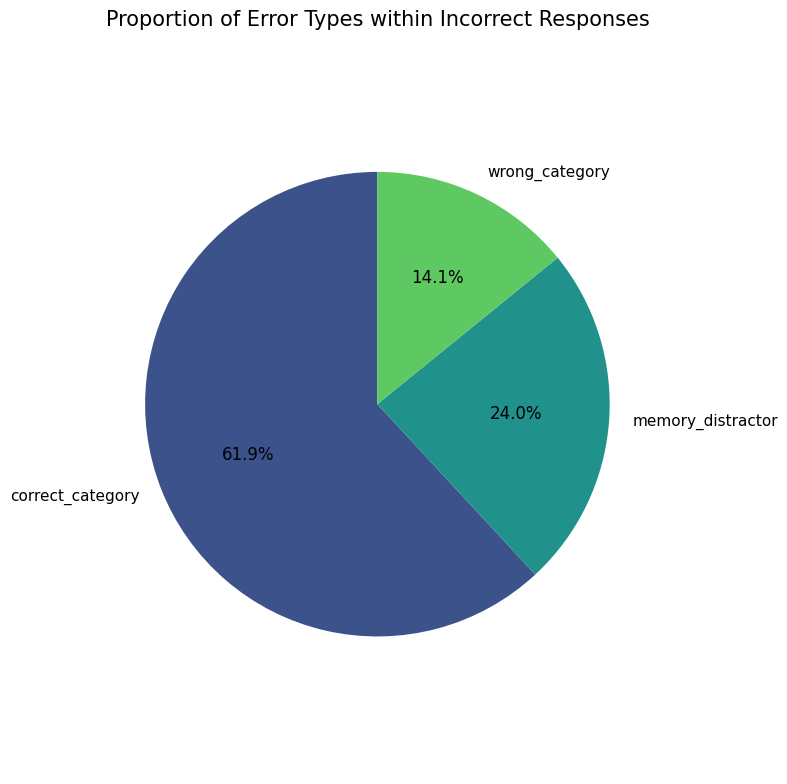

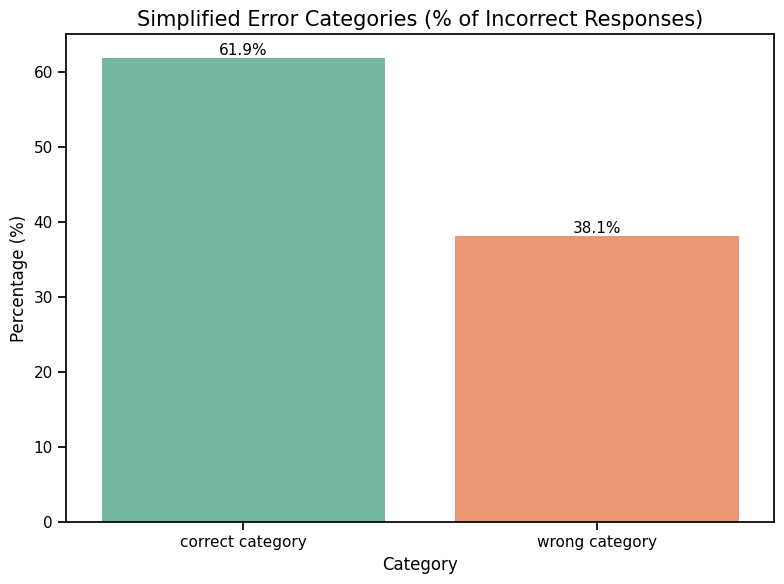

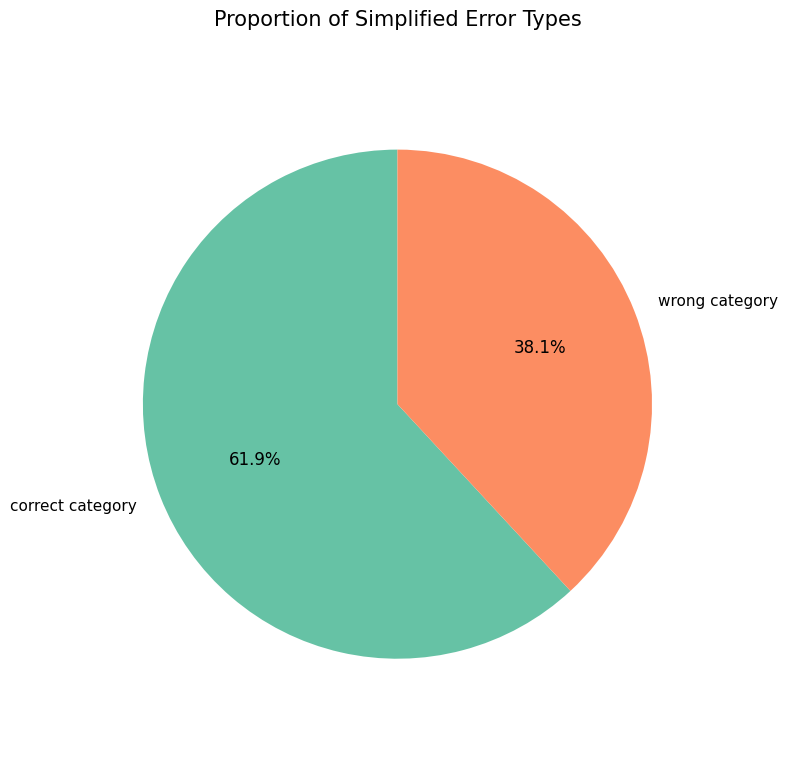

In [23]:
plt.figure(figsize=(8, 8))
plt.pie(error_percentages.values, labels=error_percentages.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette("viridis", len(error_percentages)))
plt.title('Proportion of Error Types within Incorrect Responses', fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

# If we have the simplified WM Choice Category, visualize that as well
if 'WM Choice Category' in df_cleaned.columns:
    wm_percentages = df_cleaned['WM Choice Category'].value_counts(normalize=True) * 100
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=wm_percentages.index, y=wm_percentages.values, palette="Set2")
    plt.title('Simplified Error Categories (% of Incorrect Responses)', fontsize=15)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    
    # Add percentage labels on top of each bar
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Pie chart for simplified categories
    plt.figure(figsize=(8, 8))
    plt.pie(wm_percentages.values, labels=wm_percentages.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("Set2", len(wm_percentages)))
    plt.title('Proportion of Simplified Error Types', fontsize=15)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

<Figure size 1000x600 with 0 Axes>

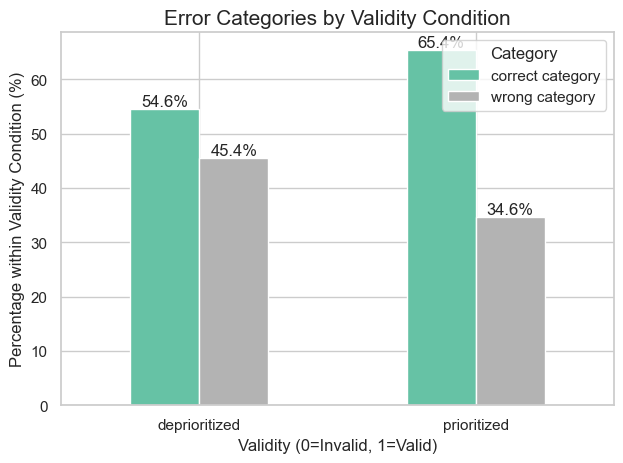

<Figure size 1000x600 with 0 Axes>

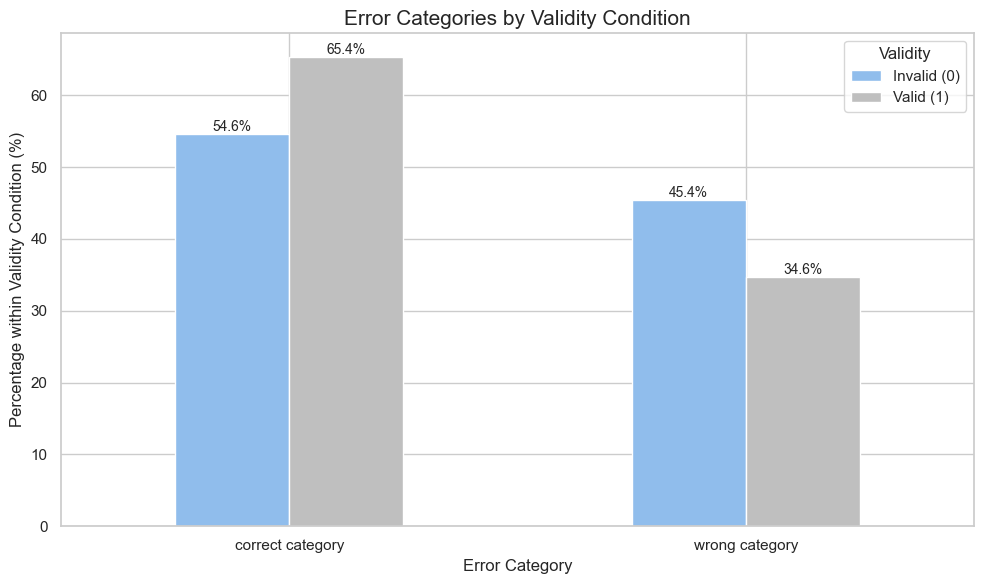

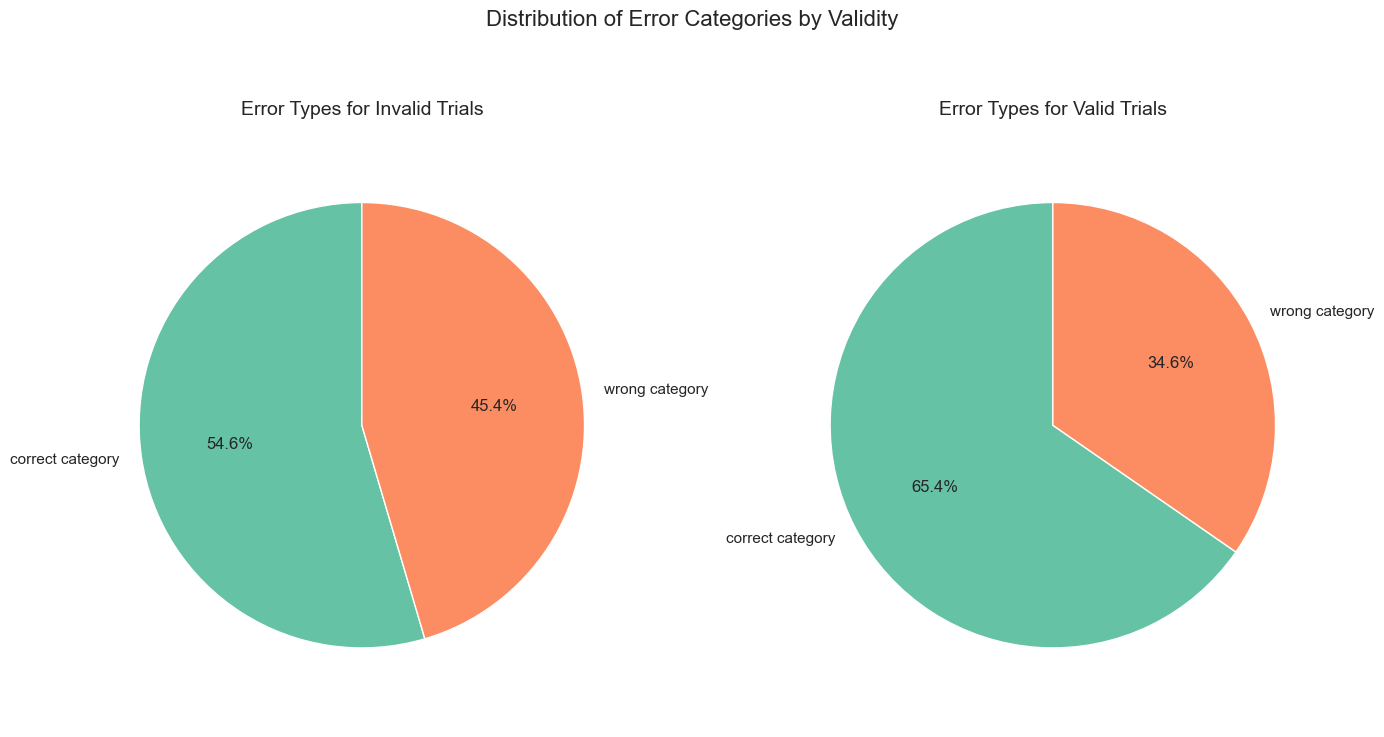


Chi-square test of independence:
Chi2 value: 165.78
p-value: 0.0000
Degrees of freedom: 1
Result: Significant association between validity and error type

Contingency table (counts):
WM Choice Category  correct category  wrong category
validity_binary                                     
0                               2706            2253
1                               6844            3627

Percentages within each validity condition:
WM Choice Category  correct category  wrong category
Tested Item                                         
deprioritized              54.567453       45.432547
prioritized                65.361475       34.638525


In [24]:

sns.set_style("whitegrid")

# Create a cross-tabulation of validity_binary vs WM Choice Category
wm_cross_tab = pd.crosstab(
    df_cleaned['Tested Item'], 
    df_cleaned['WM Choice Category'],
    normalize='index'
) * 100

# Create a bar chart
plt.figure(figsize=(10, 6))
wm_cross_tab.plot(kind='bar', colormap='Set2')
plt.title('Error Categories by Validity Condition', fontsize=15)
plt.xlabel('Validity (0=Invalid, 1=Valid)', fontsize=12)
plt.ylabel('Percentage within Validity Condition (%)', fontsize=12)
plt.legend(title='Category')
plt.xticks(rotation=0)

# Add percentage labels
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

# Create a side-by-side bar chart for clearer comparison
plt.figure(figsize=(10, 6))
wm_cross_tab_flipped = pd.crosstab(
    df_cleaned['WM Choice Category'],
    df_cleaned['validity_binary'],
    normalize='columns'
) * 100

# Plot grouped bars
ax = wm_cross_tab_flipped.plot(kind='bar', figsize=(10, 6))
plt.title('Error Categories by Validity Condition', fontsize=15)
plt.xlabel('Error Category', fontsize=12)
plt.ylabel('Percentage within Validity Condition (%)', fontsize=12)
plt.legend(['Invalid (0)', 'Valid (1)'], title='Validity')
plt.xticks(rotation=0)

# Add percentage labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=10)

plt.tight_layout()
plt.show()

# Create a pie chart for each validity condition
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Get data for each validity condition
for i, validity in enumerate([0, 1]):
    validity_data = df_cleaned[df_cleaned['validity_binary'] == validity]
    wm_counts = validity_data['WM Choice Category'].value_counts()
    wm_percentages = wm_counts / len(validity_data) * 100
    
    axes[i].pie(wm_percentages, labels=wm_percentages.index, autopct='%1.1f%%', 
                startangle=90, colors=sns.color_palette("Set2", len(wm_percentages)))
    axes[i].set_title(f'Error Types for {"Invalid" if validity == 0 else "Valid"} Trials', fontsize=14)
    axes[i].axis('equal')

plt.suptitle('Distribution of Error Categories by Validity', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Statistical test: Chi-square test of independence
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_cleaned['validity_binary'], df_cleaned['WM Choice Category'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test of independence:")
print(f"Chi2 value: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Result: {'Significant association between validity and error type' if p < 0.05 else 'No significant association between validity and error type'}")

# Print the raw counts and percentages for reference
print("\nContingency table (counts):")
print(contingency_table)

print("\nPercentages within each validity condition:")
print(wm_cross_tab)

<Figure size 1000x600 with 0 Axes>

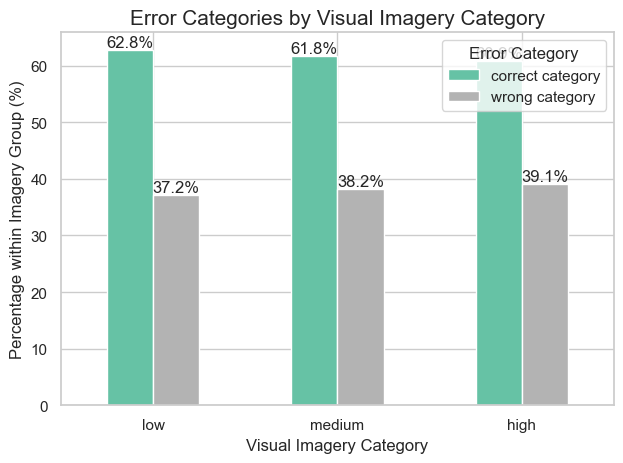

<Figure size 1000x600 with 0 Axes>

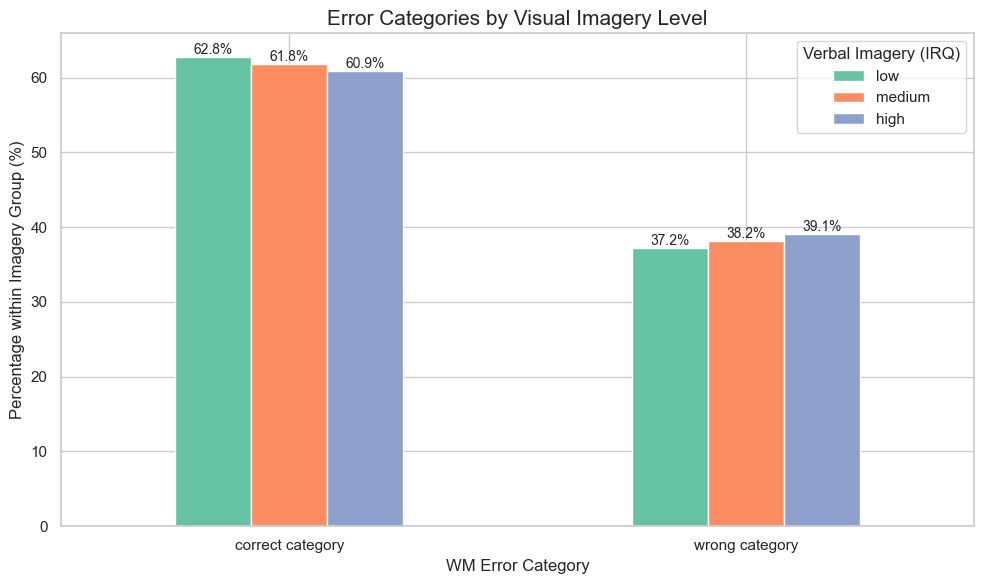

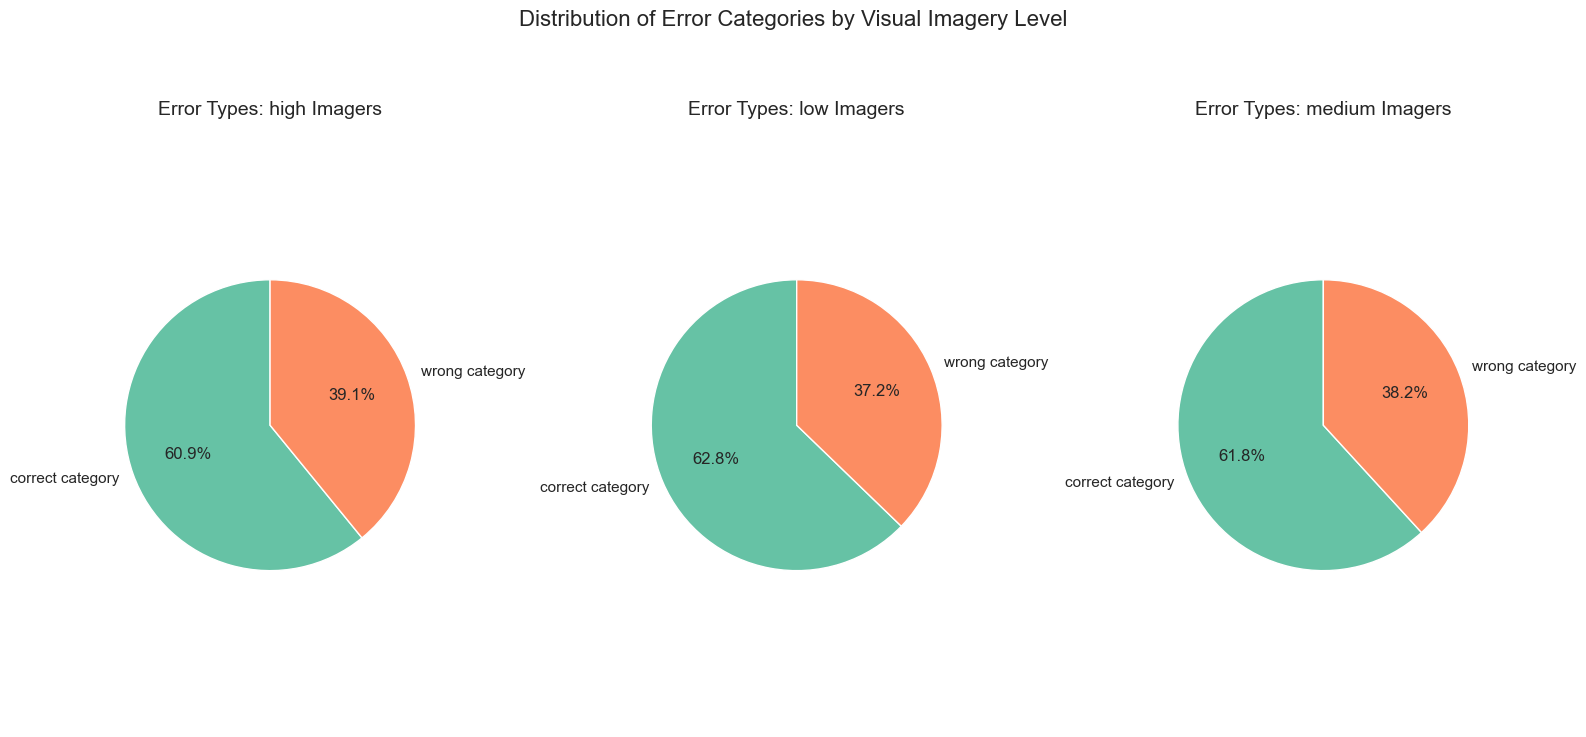


Chi-square test of independence:
Chi2 value: 3.73
p-value: 0.1551
Degrees of freedom: 2
Result: No significant association

Contingency table (counts):
WM Choice Category  correct category  wrong category
irq_visual_cat                                      
low                             3473            2059
medium                          3405            2105
high                            2672            1716

Percentages within each imagery group:
WM Choice Category  correct category  wrong category
irq_visual_cat                                      
low                        62.780188       37.219812
medium                     61.796733       38.203267
high                       60.893345       39.106655


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Set style
sns.set_style("whitegrid")

# 1. Cross-tabulation and bar chart (percent within imagery category)
wm_cross_tab = pd.crosstab(
    df_cleaned['irq_visual_cat'], 
    df_cleaned['WM Choice Category'],
    normalize='index'
) * 100

# Bar chart: Error Types by Visual Imagery Category
plt.figure(figsize=(10, 6))
wm_cross_tab.plot(kind='bar', colormap='Set2')
plt.title('Error Categories by Visual Imagery Category', fontsize=15)
plt.xlabel('Visual Imagery Category', fontsize=12)
plt.ylabel('Percentage within Imagery Group (%)', fontsize=12)
plt.legend(title='Error Category')
plt.xticks(rotation=0)

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

# 2. Side-by-side bar chart (percent within each error type)
wm_cross_tab_flipped_verbal = pd.crosstab(
    df_cleaned['WM Choice Category'],
    df_cleaned['irq_visual_cat'],
    normalize='columns'
) * 100

# Define a 3-color palette
palette_verbal = sns.color_palette("Set2", 3)

plt.figure(figsize=(10, 6))
ax = wm_cross_tab_flipped_verbal.plot(
    kind='bar',
    figsize=(10, 6),
    color=palette_verbal  # ensure 3-color mapping
)
plt.title('Error Categories by Visual Imagery Level', fontsize=15)
plt.xlabel('WM Error Category', fontsize=12)
plt.ylabel('Percentage within Imagery Group (%)', fontsize=12)
plt.legend(title='Verbal Imagery (IRQ)')
plt.xticks(rotation=0)

# Add percentage labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=10)

plt.tight_layout()
plt.show()

# 3. Pie charts for each imagery category
categories = df_cleaned['irq_visual_cat'].unique()
fig, axes = plt.subplots(1, len(categories), figsize=(16, 7))

for i, cat in enumerate(sorted(categories)):
    category_data = df_cleaned[df_cleaned['irq_visual_cat'] == cat]
    wm_counts = category_data['WM Choice Category'].value_counts()
    wm_percentages = wm_counts / len(category_data) * 100

    axes[i].pie(wm_percentages, labels=wm_percentages.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set2", len(wm_percentages)))
    axes[i].set_title(f'Error Types: {cat} Imagers', fontsize=14)
    axes[i].axis('equal')

plt.suptitle('Distribution of Error Categories by Visual Imagery Level', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# 4. Chi-square test
contingency_table = pd.crosstab(df_cleaned['irq_visual_cat'], df_cleaned['WM Choice Category'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test of independence:")
print(f"Chi2 value: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Result: {'Significant association between imagery and error type' if p < 0.05 else 'No significant association'}")

print("\nContingency table (counts):")
print(contingency_table)

print("\nPercentages within each imagery group:")
print(wm_cross_tab)


<Figure size 1000x600 with 0 Axes>

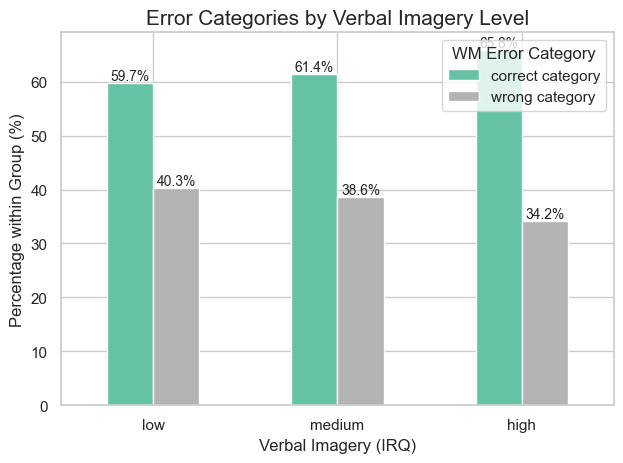

<Figure size 1000x600 with 0 Axes>

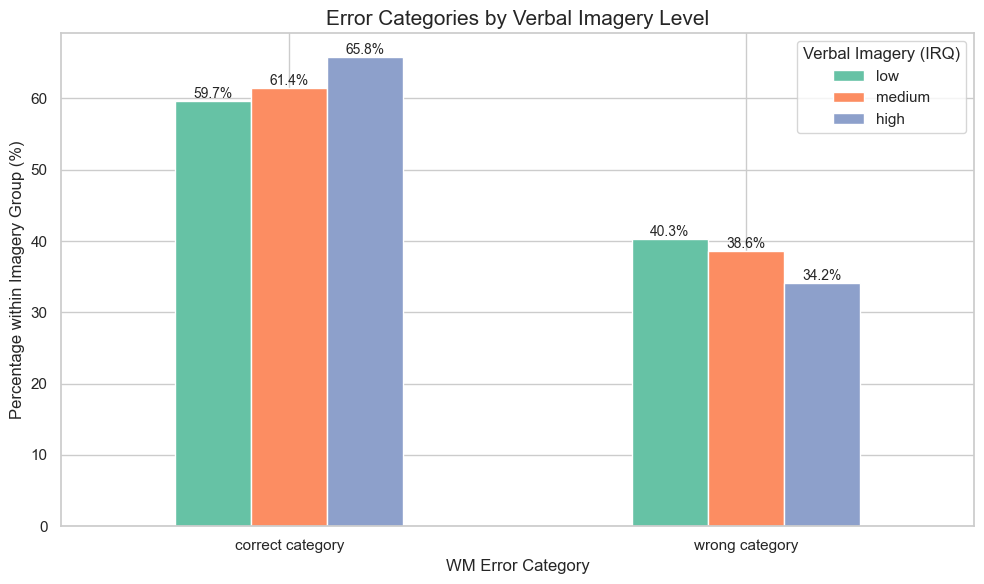

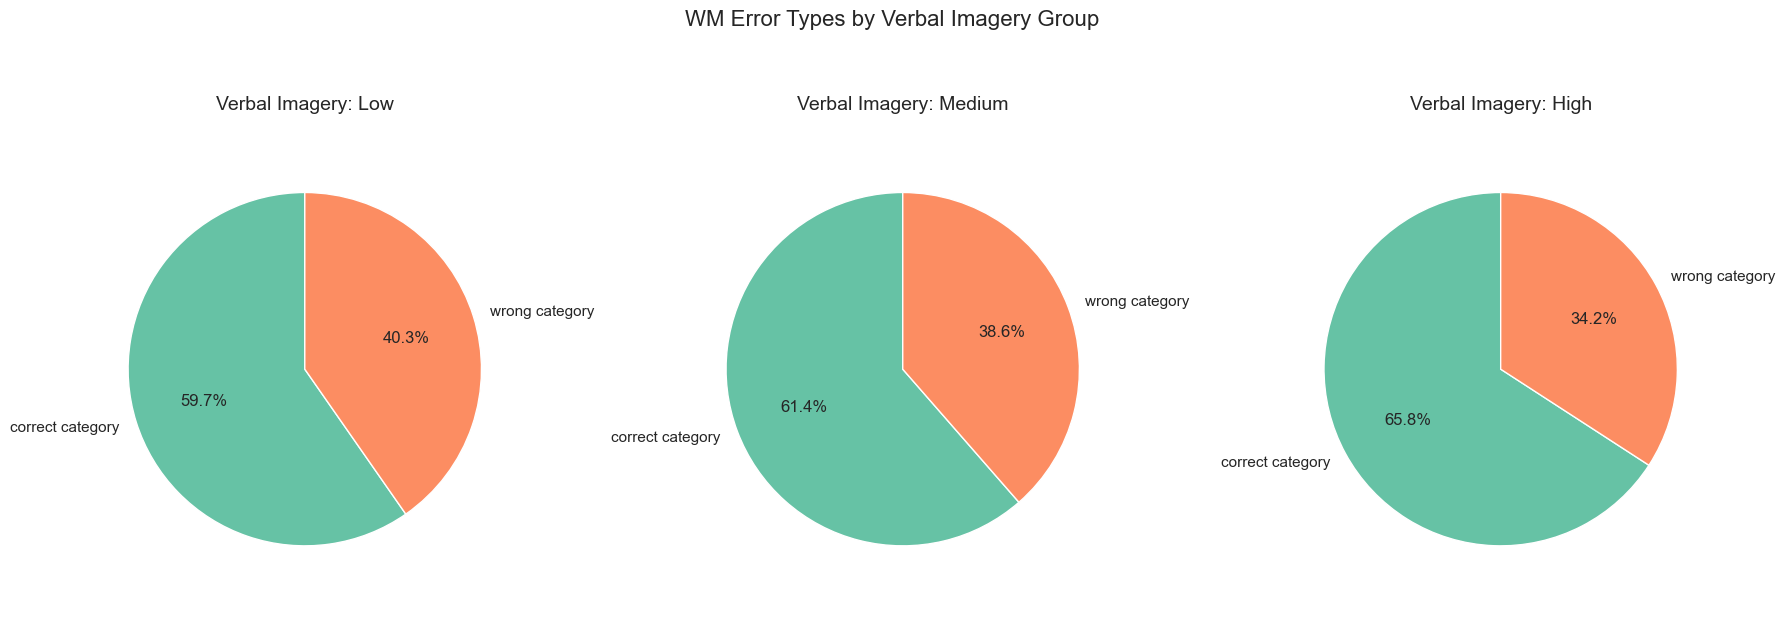


Chi-square test of independence:
Chi2 value: 38.88
p-value: 0.0000
Degrees of freedom: 2
Result: Significant association between imagery and error type

Contingency table (counts):
WM Choice Category  correct category  wrong category
irq_verbal_cat                                      
low                             3521            2378
medium                          3428            2153
high                            2601            1349

Percentages within each imagery level:
WM Choice Category  correct category  wrong category
irq_verbal_cat                                      
low                        59.688083       40.311917
medium                     61.422684       38.577316
high                       65.848101       34.151899


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency

sns.set_style("whitegrid")

# --- Cross-tab: percentage within each imagery group ---
wm_cross_tab_verbal = pd.crosstab(
    df_cleaned['irq_verbal_cat'],
    df_cleaned['WM Choice Category'],
    normalize='index'
) * 100

# Bar chart: Error types by verbal imagery
plt.figure(figsize=(10, 6))
wm_cross_tab_verbal.plot(kind='bar', colormap='Set2')
plt.title('Error Categories by Verbal Imagery Level', fontsize=15)
plt.xlabel('Verbal Imagery (IRQ)', fontsize=12)
plt.ylabel('Percentage within Group (%)', fontsize=12)
plt.legend(title='WM Error Category')
plt.xticks(rotation=0)

# Add percentage labels
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%', fontsize=10)

plt.tight_layout()
plt.show()

# --- Side-by-side bar chart (error category focus) ---
wm_cross_tab_flipped_verbal = pd.crosstab(
    df_cleaned['WM Choice Category'],
    df_cleaned['irq_verbal_cat'],
    normalize='columns'
) * 100

# Define a 3-color palette
palette_verbal = sns.color_palette("Set2", 3)

plt.figure(figsize=(10, 6))
ax = wm_cross_tab_flipped_verbal.plot(
    kind='bar',
    figsize=(10, 6),
    color=palette_verbal  # ensure 3-color mapping
)
plt.title('Error Categories by Verbal Imagery Level', fontsize=15)
plt.xlabel('WM Error Category', fontsize=12)
plt.ylabel('Percentage within Imagery Group (%)', fontsize=12)
plt.legend(title='Verbal Imagery (IRQ)')
plt.xticks(rotation=0)

# Add percentage labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=10)

plt.tight_layout()
plt.show()

# --- Pie charts for each imagery level ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, level in enumerate(['low', 'medium', 'high']):
    subset = df_cleaned[df_cleaned['irq_verbal_cat'] == level]
    wm_counts = subset['WM Choice Category'].value_counts()
    wm_percentages = wm_counts / len(subset) * 100

    axes[i].pie(wm_percentages, labels=wm_percentages.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set2", len(wm_percentages)))
    axes[i].set_title(f'Verbal Imagery: {level.capitalize()}', fontsize=14)
    axes[i].axis('equal')

plt.suptitle('WM Error Types by Verbal Imagery Group', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# --- Chi-square test ---
contingency_verbal = pd.crosstab(df_cleaned['irq_verbal_cat'], df_cleaned['WM Choice Category'])
chi2, p, dof, expected = chi2_contingency(contingency_verbal)

print(f"\nChi-square test of independence:")
print(f"Chi2 value: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Result:", "Significant association between imagery and error type" if p < 0.05 else "No significant association")

# Print raw counts and row percentages
print("\nContingency table (counts):")
print(contingency_verbal)

print("\nPercentages within each imagery level:")
print(wm_cross_tab_verbal)


Distribution of Tested Item values:
Tested Item
prioritized      10471
deprioritized     4959
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

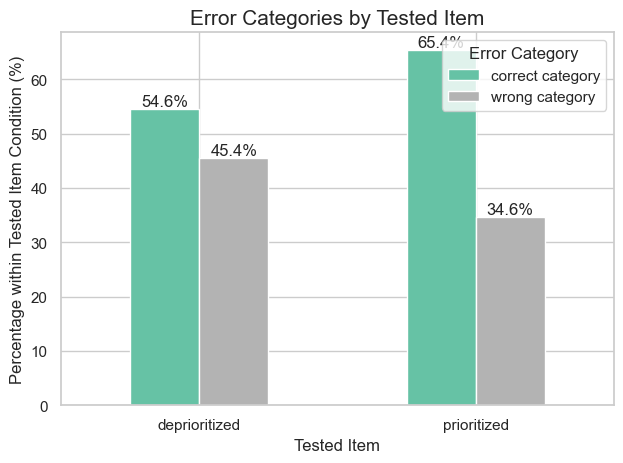

<Figure size 1000x600 with 0 Axes>

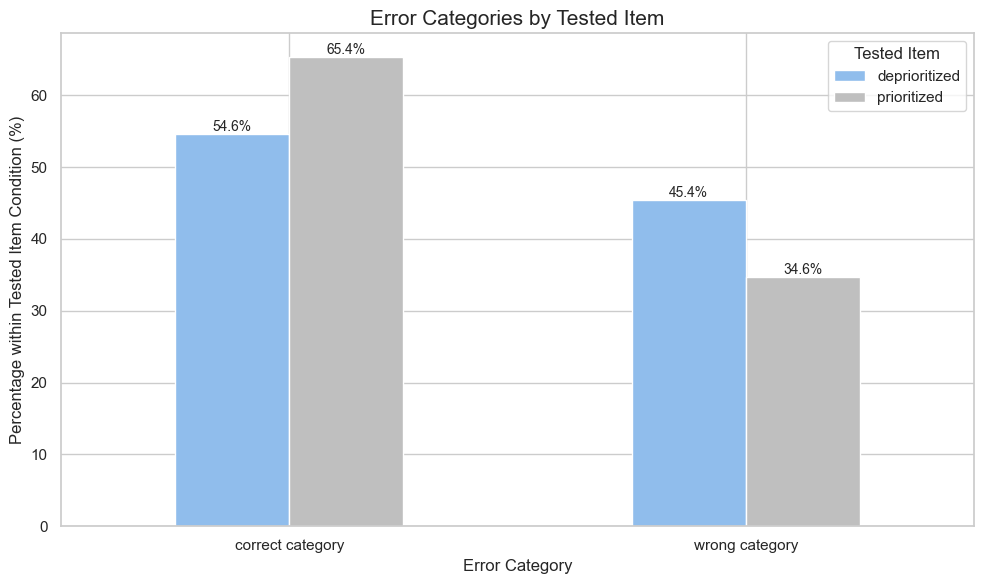

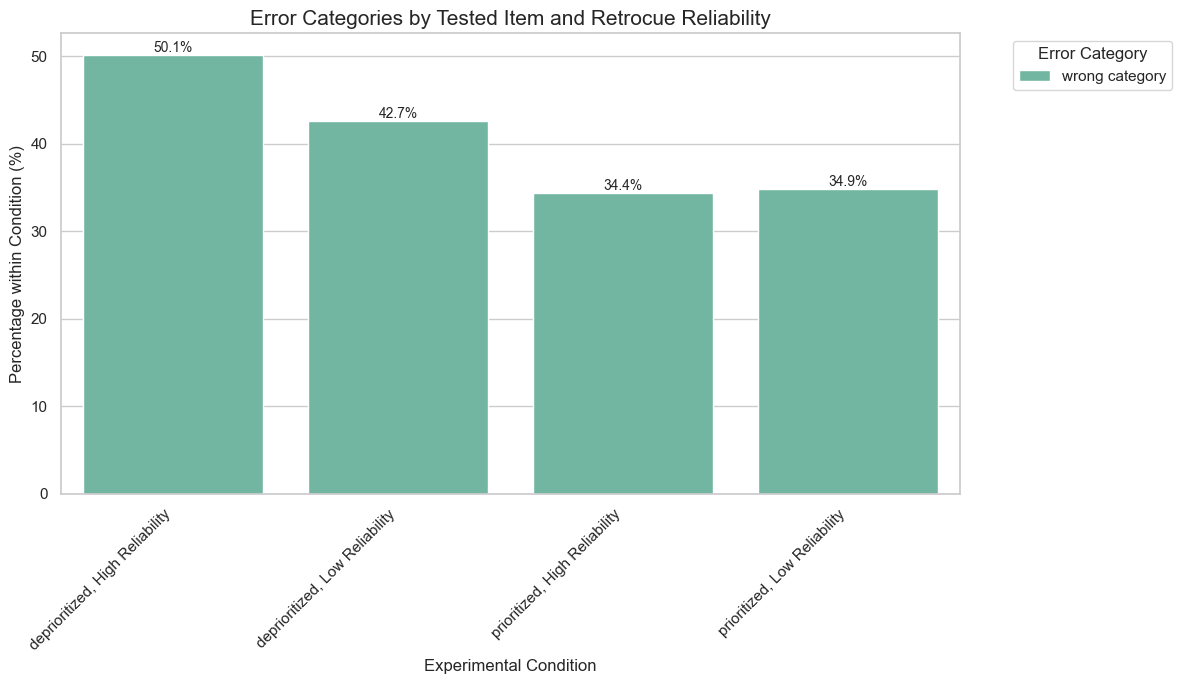

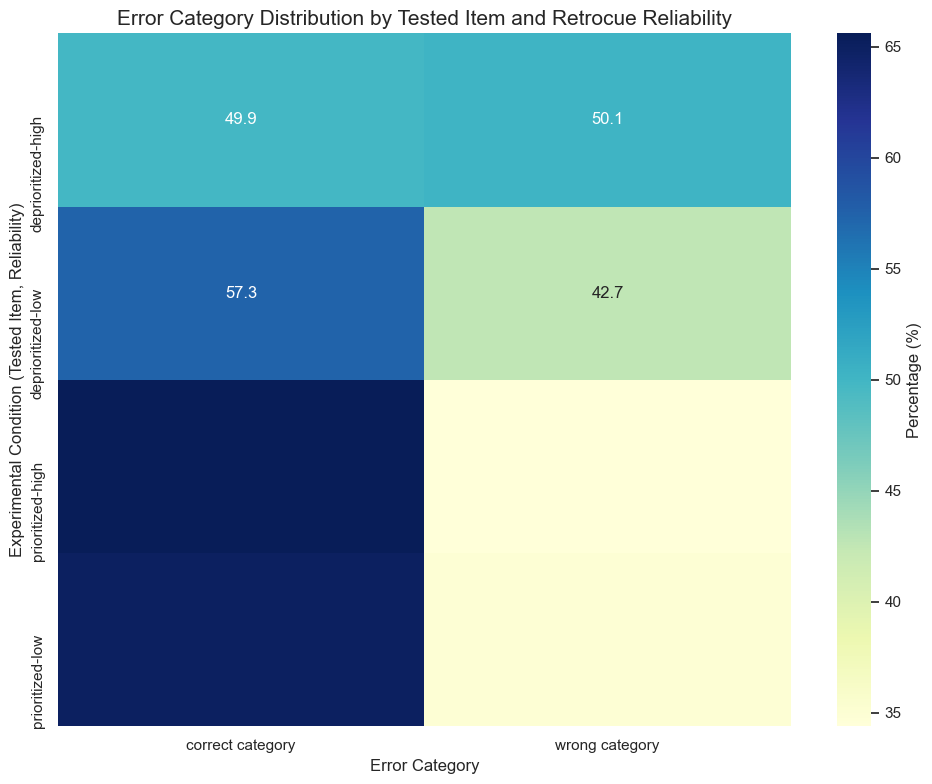

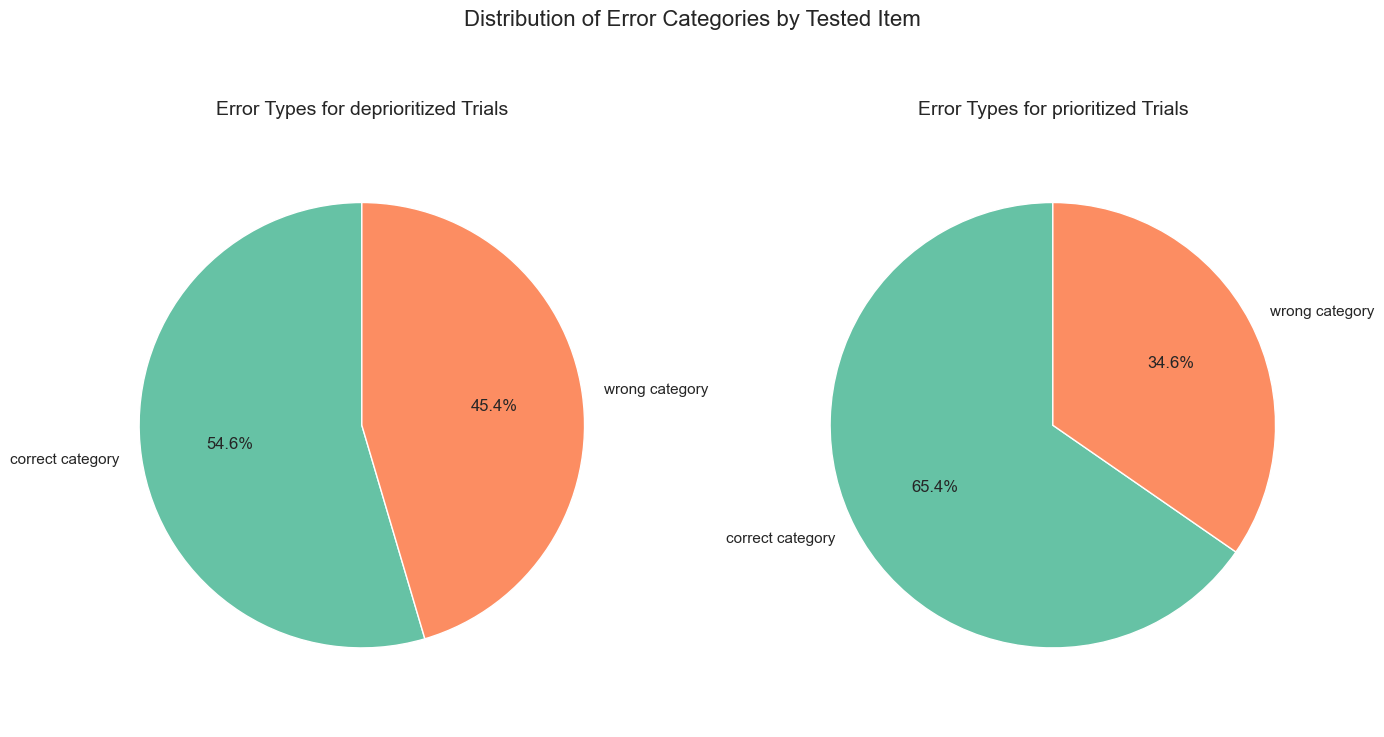


Statistical Tests:

1. Tested Item vs. Error Type:
Chi2 value: 165.78
p-value: 0.0000
Result: Significant association

2. Retrocue Reliability vs. Error Type:
Chi2 value: 0.32
p-value: 0.5721
Result: No significant association

3. Three-way contingency table (counts):
WM Choice Category                  correct category  wrong category
Tested Item   Retrocue Reliability                                  
deprioritized high                               919             924
              low                               1787            1329
prioritized   high                              3607            1891
              low                               3237            1736

Percentages within each condition combination:
WM Choice Category                  correct category  wrong category
Tested Item   Retrocue Reliability                                  
deprioritized high                         49.864352       50.135648
              low                          57.349166       42

In [27]:


# Set the style for better-looking plots
sns.set_style("whitegrid")

# First, verify the values in the "Tested Item" column
tested_item_counts = df_cleaned['Tested Item'].value_counts()
print("Distribution of Tested Item values:")
print(tested_item_counts)

# Create a cross-tabulation of Tested Item vs WM Choice Category
tested_item_cross_tab = pd.crosstab(
    df_cleaned['Tested Item'], 
    df_cleaned['WM Choice Category'],
    normalize='index'
) * 100

# Create a bar chart for Tested Item
plt.figure(figsize=(10, 6))
tested_item_cross_tab.plot(kind='bar', colormap='Set2')
plt.title('Error Categories by Tested Item', fontsize=15)
plt.xlabel('Tested Item', fontsize=12)
plt.ylabel('Percentage within Tested Item Condition (%)', fontsize=12)
plt.legend(title='Error Category')
plt.xticks(rotation=0)

# Add percentage labels
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

# Create a side-by-side bar chart for clearer comparison
plt.figure(figsize=(10, 6))
tested_item_cross_tab_flipped = pd.crosstab(
    df_cleaned['WM Choice Category'],
    df_cleaned['Tested Item'],
    normalize='columns'
) * 100

# Plot grouped bars
ax = tested_item_cross_tab_flipped.plot(kind='bar', figsize=(10, 6))
plt.title('Error Categories by Tested Item', fontsize=15)
plt.xlabel('Error Category', fontsize=12)
plt.ylabel('Percentage within Tested Item Condition (%)', fontsize=12)
plt.legend(title='Tested Item')
plt.xticks(rotation=0)

# Add percentage labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=10)

plt.tight_layout()
plt.show()

# Create a cross-tabulation with both factors (Tested Item and Retrocue Reliability)
combined_cross_tab = pd.crosstab(
    [df_cleaned['Tested Item'], df_cleaned['Retrocue Reliability']], 
    df_cleaned['WM Choice Category'],
    normalize='index'
) * 100

# Reset the index to make it more readable
combined_cross_tab = combined_cross_tab.reset_index()
combined_cross_tab['condition'] = combined_cross_tab.apply(
    lambda x: f"{x['Tested Item']}, {'Low' if x['Retrocue Reliability'] == 'low' else 'High'} Reliability", 
    axis=1
)

# Reshape for plotting
plot_data = pd.melt(
    combined_cross_tab, 
    id_vars=['condition'], 
    value_vars=combined_cross_tab.columns[3:],
    var_name='Error Category', 
    value_name='Percentage'
)

# Create a grouped bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x='condition', y='Percentage', hue='Error Category', data=plot_data, palette='Set2')
plt.title('Error Categories by Tested Item and Retrocue Reliability', fontsize=15)
plt.xlabel('Experimental Condition', fontsize=12)
plt.ylabel('Percentage within Condition (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Error Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels
for i, p in enumerate(plt.gca().patches):
    percentage = p.get_height()
    if percentage > 5:  # Only label percentages greater than 5% for clarity
        plt.gca().annotate(f'{percentage:.1f}%', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Create a heatmap for a different visualization approach
# Prepare data for heatmap (reshape the crosstab)
heatmap_data = pd.crosstab(
    [df_cleaned['Tested Item'], df_cleaned['Retrocue Reliability']], 
    df_cleaned['WM Choice Category'],
    normalize='index'
) * 100

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': 'Percentage (%)'})
plt.title('Error Category Distribution by Tested Item and Retrocue Reliability', fontsize=15)
plt.ylabel('Experimental Condition (Tested Item, Reliability)', fontsize=12)
plt.xlabel('Error Category', fontsize=12)
plt.tight_layout()
plt.show()

# Create pie charts for each Tested Item condition
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Get unique values in Tested Item
tested_item_values = df_cleaned['Tested Item'].unique()

# Get data for each Tested Item condition
for i, tested_item in enumerate(tested_item_values[:2]):  # Limit to first two values if there are more
    tested_item_data = df_cleaned[df_cleaned['Tested Item'] == tested_item]
    wm_counts = tested_item_data['WM Choice Category'].value_counts()
    wm_percentages = wm_counts / len(tested_item_data) * 100
    
    axes[i].pie(wm_percentages, labels=wm_percentages.index, autopct='%1.1f%%', 
                startangle=90, colors=sns.color_palette("Set2", len(wm_percentages)))
    axes[i].set_title(f'Error Types for {tested_item} Trials', fontsize=14)
    axes[i].axis('equal')

plt.suptitle('Distribution of Error Categories by Tested Item', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Statistical analysis: Chi-square tests
from scipy.stats import chi2_contingency

# Create contingency tables for different analyses
print("\nStatistical Tests:")

# 1. Association between Tested Item and Error Type
tested_item_table = pd.crosstab(df_cleaned['Tested Item'], df_cleaned['WM Choice Category'])
chi2_tested_item, p_tested_item, dof_tested_item, expected_tested_item = chi2_contingency(tested_item_table)
print(f"\n1. Tested Item vs. Error Type:")
print(f"Chi2 value: {chi2_tested_item:.2f}")
print(f"p-value: {p_tested_item:.4f}")
print(f"Result: {'Significant association' if p_tested_item < 0.05 else 'No significant association'}")

# 2. Association between Retrocue Reliability and Error Type
reliability_table = pd.crosstab(df_cleaned['Retrocue Reliability'], df_cleaned['WM Choice Category'])
chi2_reliability, p_reliability, dof_reliability, expected_reliability = chi2_contingency(reliability_table)
print(f"\n2. Retrocue Reliability vs. Error Type:")
print(f"Chi2 value: {chi2_reliability:.2f}")
print(f"p-value: {p_reliability:.4f}")
print(f"Result: {'Significant association' if p_reliability < 0.05 else 'No significant association'}")

# 3. Three-way contingency table analysis
# Create a three-way contingency table
three_way_table = pd.crosstab(
    [df_cleaned['Tested Item'], df_cleaned['Retrocue Reliability']], 
    df_cleaned['WM Choice Category']
)
print("\n3. Three-way contingency table (counts):")
print(three_way_table)

# Print the percentages for reference
print("\nPercentages within each condition combination:")
print(heatmap_data)

In [45]:
# Select only error trials: clicked item ≠ target
df_errors = df_cleaned[df_cleaned['last_clicked_category'] != 'target']
# 1 = clicked an item from the same semantic category
df_errors['same_category_error'] = (df_errors['last_clicked_category'] == 'correct_category').astype(int)


In [59]:
df_errors.to_csv("../data/df_errors.csv", index=False)